## Visualization

In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(magrittr); library(zeallot); library(glue);  library(glue); library(lubridate)
    library(scales); library(RColorBrewer); library(dplyr); library(tidyr); library(ggplot2)
    library(ggthemes); library(polloi)
})

In [2]:
file <- "metrics/metrics.tsv"
pageview <- read.csv(file, sep = '\t')
pageview$month <- as.Date(pageview$month, format = "%Y-%m-%d")

In [3]:
head(pageview)

,month,automated_pageviews,desktop,gs_interactions,gs_pageviews,gs_previews,interactions,mh_interactions,mh_pageviews,mh_previews,mobileweb,previews_seen,total_pageview,unique_devices
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2016-07-01,NA,7319709535,NA,NA,NA,NA,NA,NA,NA,6951477838,NA,14479097793,NA
2,2016-08-01,NA,7808198322,NA,NA,NA,NA,NA,NA,NA,7158465508,NA,15164063733,NA
3,2016-09-01,NA,8015803318,NA,3509314705,NA,NA,NA,482166702,NA,7037821889,NA,15227361307,NA
4,2016-10-01,NA,8597813074,NA,3649168724,NA,NA,NA,584002147,NA,7454268064,NA,16205992870,NA
5,2016-11-01,NA,8756368629,NA,3682761207,NA,NA,NA,639332261,NA,7568847051,NA,16499874726,NA
6,2016-12-01,NA,8140608026,NA,3397813382,NA,NA,NA,566587960,NA,7623805561,NA,15964600507,NA


In [4]:
tail(pageview)

,month,automated_pageviews,desktop,gs_interactions,gs_pageviews,gs_previews,interactions,mh_interactions,mh_pageviews,mh_previews,mobileweb,previews_seen,total_pageview,unique_devices
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
60,2021-06-01,983769895,6110733433,4260437339,3863986855,396450484,17850494493,780696296,749482516,31213780,9703933570,1773353101,16077141392,1745605374
61,2021-07-01,854652668,6205219758,4427486243,4050288368,377197875,18091145007,787963591,757767051,30196540,9884966150,1721154978,16369990029,1700403629
62,2021-08-01,1012844733,6437804137,4492513177,4169962401,322550776,18199559765,858994724,831021702,27973022,10024122503,1451793555,16747766210,1825274131
63,2021-09-01,911629620,6293941138,4342241993,3949492178,392749815,17823784700,821283216,788543740,32739476,9454794487,1812546943,16011237757,1690496559
64,2021-10-01,901158808,6513036102,4356291999,3973495245,382796754,18360031885,NA,NA,NA,9701242496,1872863674,16487168211,1837564335
65,2021-11-01,881050513,6420327046,4247671454,3868069777,379601677,17768512101,NA,NA,NA,9209694162,1880481379,15888030722,1730051225


### Pageviews Interactions 

In [5]:
pageview_fy <- pageview %>% 
     select(month,total_pageview,previews_seen) %>%
     mutate(previews_seen = replace_na(previews_seen, 0)) %>%
     mutate(interactions = total_pageview+previews_seen) %>%
     filter(month >= '2019-07-01') %>%
     mutate(fiscal_year = ifelse(month >= '2019-07-01' & month < '2020-07-01', 'FY 2019/20', ifelse(month <'2019-07-01','FY 2018/19',ifelse(month <'2021-07-01','FY 2020/21','FY 2021/22'))),
           MonthN =as.factor(format(as.Date(month),"%m")),
         Month = months(as.Date(month), abbreviate=TRUE))

pageview_fy$MonthN = factor(pageview_fy$MonthN, levels=c("07","08", "09", "10", "11", "12", "01", "02", "03", "04", "05", "06"))

In [6]:
tail(pageview_fy)

,month,total_pageview,previews_seen,interactions,fiscal_year,MonthN,Month
,<date>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<chr>
24,2021-06-01,16077141392,1773353101,17850494493,FY 2020/21,06,Jun
25,2021-07-01,16369990029,1721154978,18091145007,FY 2021/22,07,Jul
26,2021-08-01,16747766210,1451793555,18199559765,FY 2021/22,08,Aug
27,2021-09-01,16011237757,1812546943,17823784700,FY 2021/22,09,Sep
28,2021-10-01,16487168211,1872863674,18360031885,FY 2021/22,10,Oct
29,2021-11-01,15888030722,1880481379,17768512101,FY 2021/22,11,Nov


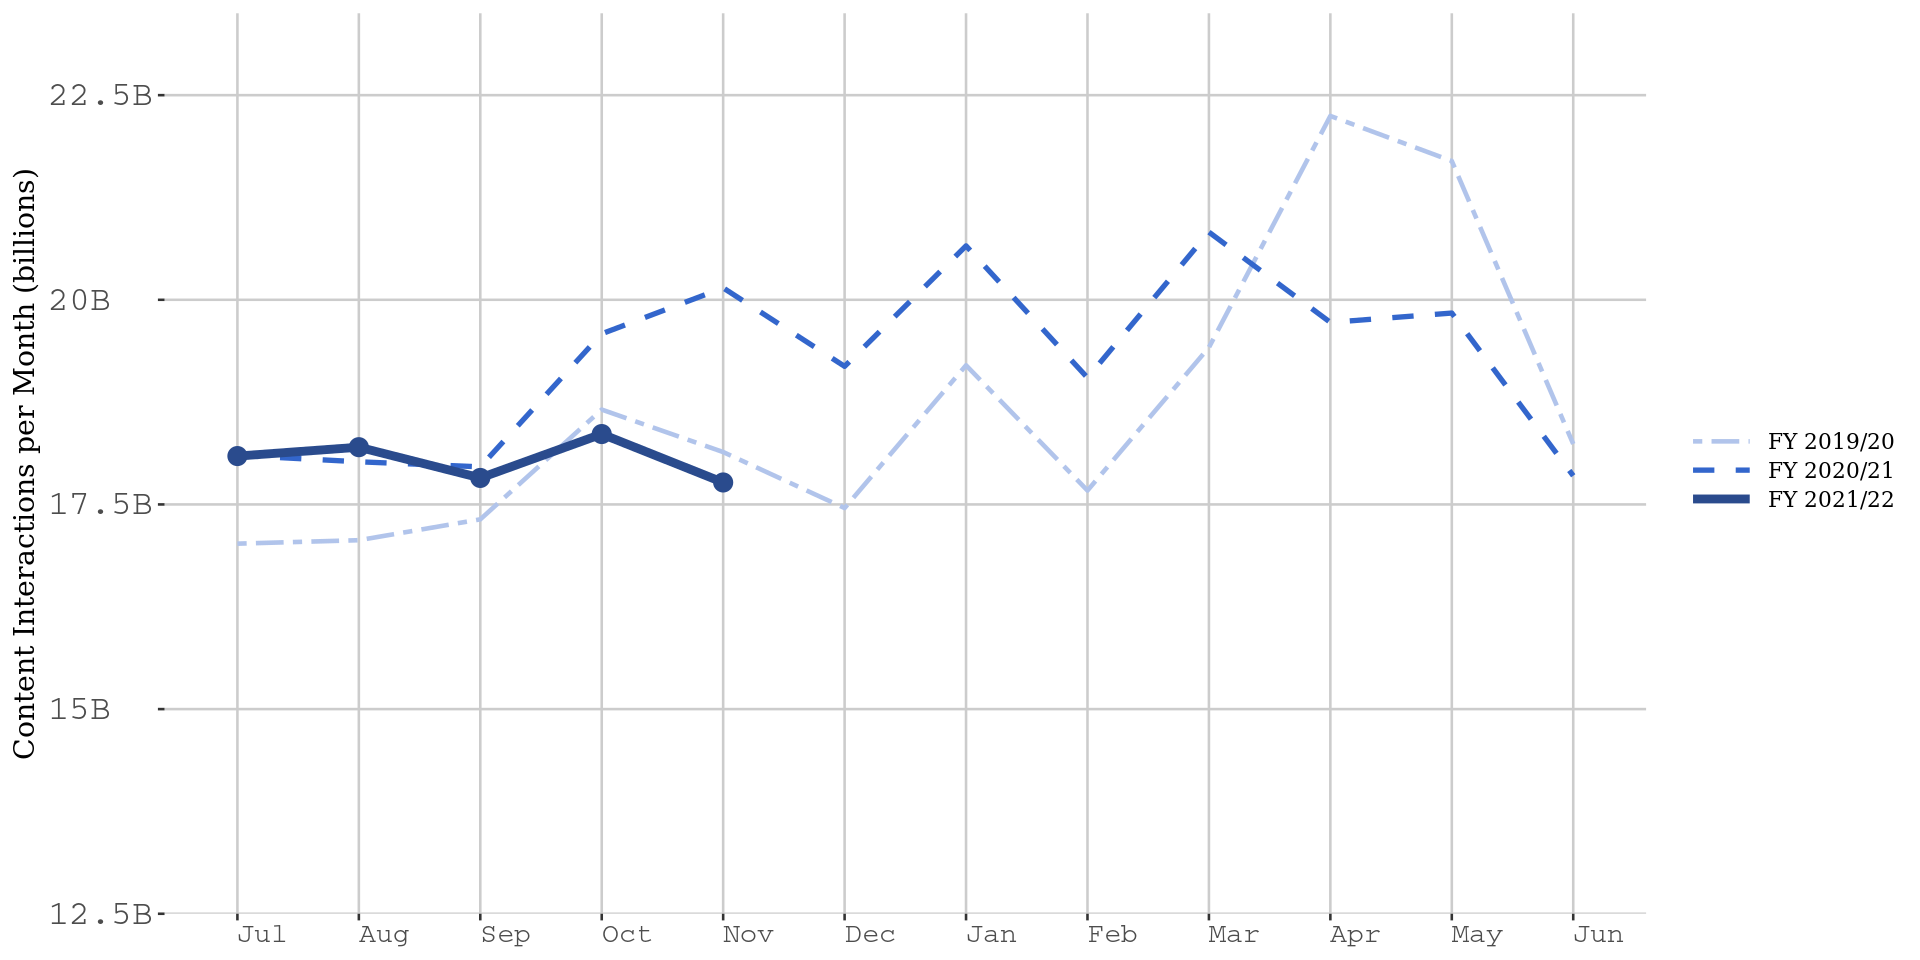

In [7]:
options(repr.plot.width = 16, repr.plot.height = 8)

p<- pageview_fy %>%
    ggplot(aes(x = MonthN)) +
    geom_line(aes(x = MonthN, y = interactions, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year)) +
    geom_point(data=pageview_fy[(pageview_fy$fiscal_year =="FY 2021/22"),],aes(x=MonthN, y=interactions, group=fiscal_year, color = fiscal_year),size = 5,color ="#2a4b8d")+

    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_size_manual(values = c(1.3,1.5,2.5)) +
    scale_color_manual(values = c("FY 2019/20"= "#b1c4eb", "FY 2020/21" = "#3366cc","FY 2021/22" = "#2a4b8d")) +
   # geom_vline(xintercept = 10, linetype = "dashed", color = "gray20") +
   # geom_text(aes(x=10, y=16.8E9, label="Page previews deployment (April 2018)"), size=5, vjust = -1, angle = 90, color = "gray20") +
   # geom_text(aes(x=10, y=16.8E9, label="China block all Wikipedias (April 2019)"), size=5, vjust = 1.5, angle = 90, color = "#b32424") +
    scale_x_discrete("Month",
                      breaks = pageview_fy$MonthN, 
                     labels = pageview_fy$Month) +
    scale_y_continuous("Content Interactions per Month (billions)",
                       labels = polloi::compress,
                       limits = c(13E9, 23E9)) +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif") +
    theme(axis.title.x=element_blank(),
         axis.text.x=element_text( hjust = 0,size = 17,family="Courier"),
           axis.text.y=element_text( hjust = 0,size = 21,family="Courier"),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=17,hjust = 0.5,vjust = -12),
          legend.position = "right", 
          panel.grid.minor.y = element_blank(),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 13),
          legend.key.width=unit(1.5,"cm"))
  p

### Interactions

In [8]:
view <- 
    pageview %>% 
    select(month,previews_seen,total_pageview,) %>%
    rename(pageviews = "total_pageview") %>%
    rename(previews = "previews_seen") %>%
    gather(type,views, pageviews:previews)
    
interaction <- pageview %>% 
    select(month,total_pageview,previews_seen) %>%
    mutate(previews_seen = replace_na(previews_seen, 0)) %>%
    mutate(interactions = total_pageview+previews_seen)

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 27 rows containing missing values (position_stack).”
Warning message:
“Removed 3 rows containing missing values (geom_col).”


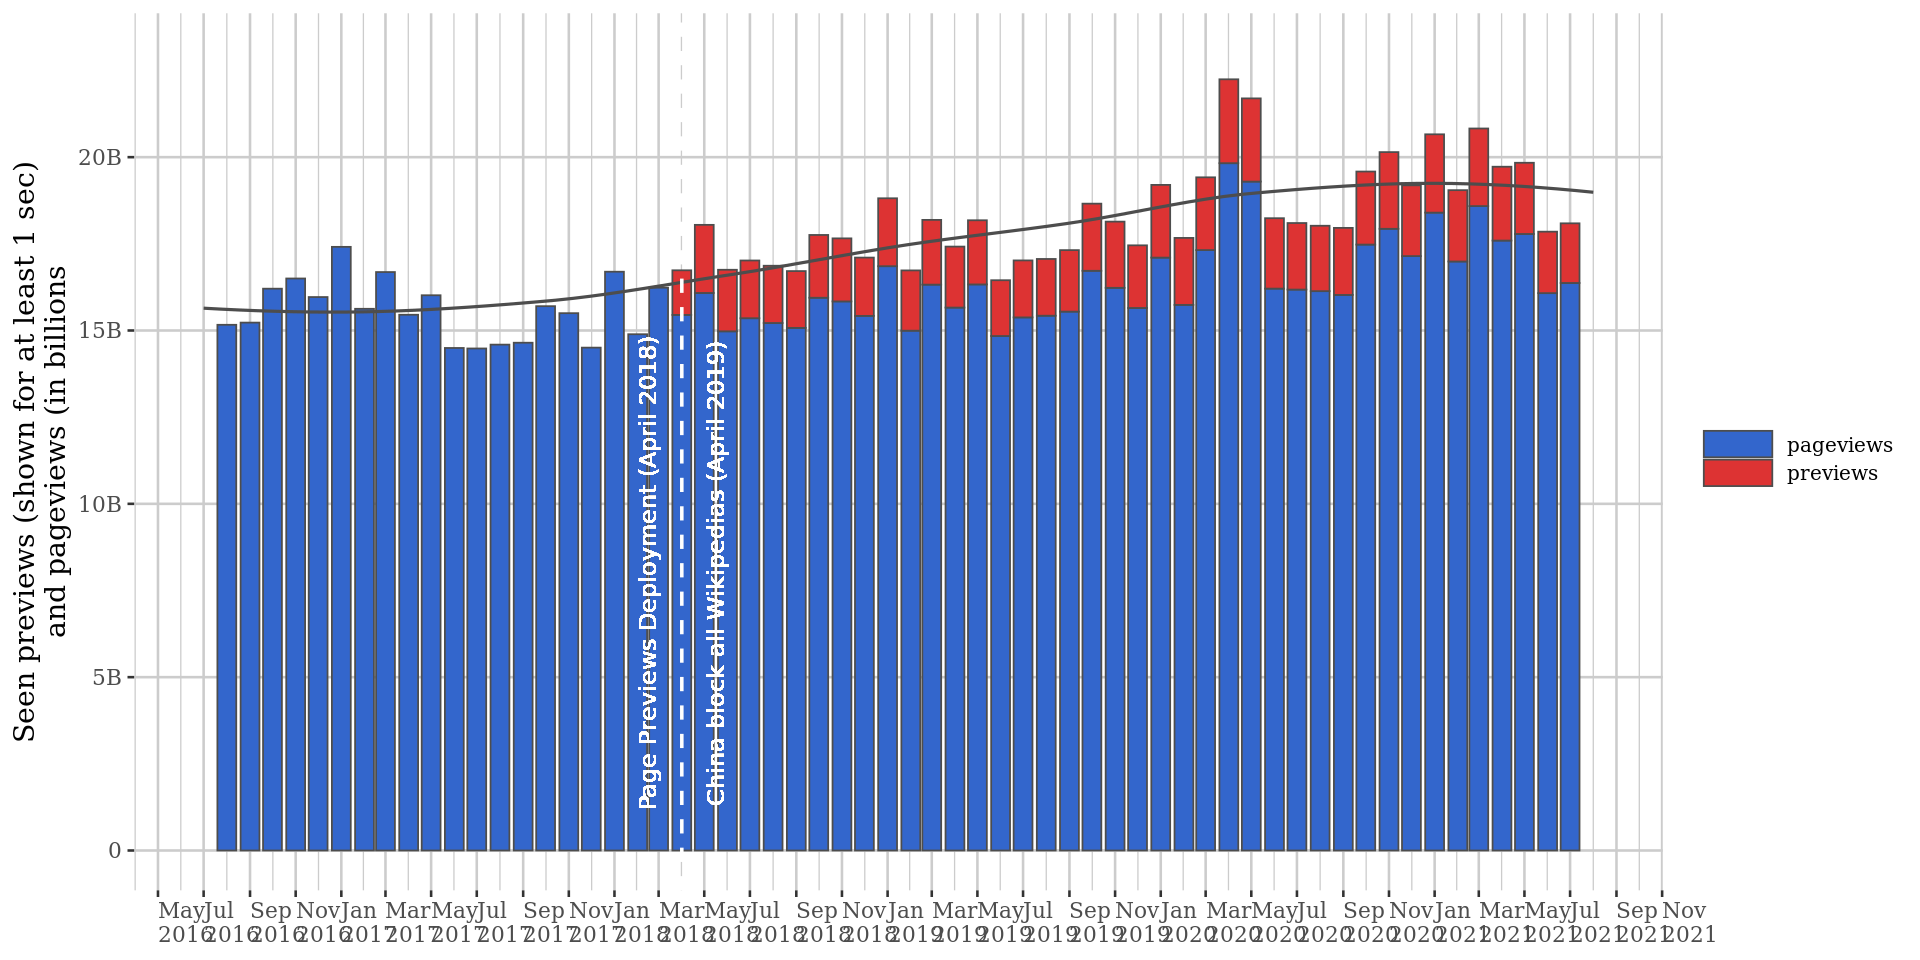

In [9]:
p<- ggplot(data = view, aes(x = month)) + 
    geom_col(data = view, mapping = aes(y = views, fill = factor(type, levels=c("previews","pageviews"))), position= "stack", color ="grey30") +
    geom_smooth(data = interaction,mapping = aes(y=interactions), method = "loess", se = FALSE, size = 0.9,color = 'grey30') +
    scale_fill_manual(values = c("pageviews" = "#3366cc","previews" = "#dd3333")) +
    scale_y_continuous("Seen previews (shown for at least 1 sec)\nand pageviews (in billions",
                       labels = polloi::compress,
                       limits = c(0, 23E9)) +
    scale_x_date("Date", 
                 labels = date_format("%b\n%Y"), 
                 date_breaks = "2 months",
                 limits= as.Date(c("2016-07-01", "2021-08-01"))) +
    geom_vline(xintercept = as.numeric(as.Date("2018-04-01")),
             linetype = "dashed", color = "white",size =1) +
    geom_text(aes(x=as.Date('2018-04-01'), y=8E9, label="Page Previews Deployment (April 2018)"), size=5, vjust = -1.5, angle = 90, color = "white") +
    geom_text(aes(x=as.Date('2018-04-01'), y=8E9, label="China block all Wikipedias (April 2019)"), size=5, vjust = 2.5, angle = 90, color = "white") +
   # labs(title = "Pageviews and seen previews per calendar month") +
    ggthemes::theme_tufte(base_size = 16,base_family = "serif")+
    theme(axis.title.x=element_blank(),
          axis.text=element_text( hjust = 0,size = 13,family="serif"),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 20,hjust = 0,face= "bold"),
          axis.title=element_text(size=17,hjust = 0.5,vjust = -12),
          legend.position = "right", 
          panel.grid.minor.y = element_blank(),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0,size = 12),
          legend.key.width=unit(1.5,"cm"))

#ggsave(filename="Pageviews and interactions_StackedBar.png", plot = p, path = 'Figures', units = "in", dpi = 192, height = 6, width = 14, limitsize = FALSE)  
p